In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns # heatmaps yay

from datetime import datetime

from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def drop_high_missing_features(df):
    tot_rec = len(df.index)
    for col in df.columns.values:
        if df[col].isnull().sum() / tot_rec > 0.15:
            del df[col]

def process_df(df):
    df['CentralAir'] = df['CentralAir'].map({'Y':1,'N':0}).astype(int)
    
    drop_high_missing_features(df)
        
    # Drop TotRmsAbvGrd - Same type of information as GrLivArea
    del df['TotRmsAbvGrd']
    # Same for GarageCars (GarageArea)
    
    
    for c in ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
              'GarageQual', 'GarageCond', 'BsmtExposure', 'BsmtFinType2', 'BsmtUnfSF',
              'BsmtFinType1', 'BsmtCond', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2', 
              'MasVnrArea', 'MasVnrType']:
        if c in df.columns.values:
            del df[c]
        
    log_list = ['LotArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
    square_root_list = ['TotalBsmtSF', 'GarageArea']

    #for l in log_list:
     #   df[l] = np.log(df[l])

    for s in square_root_list:
        df[s] = np.sqrt(df[s])

    # Sale Price is in our training data, but not testing data
    if 'SalePrice' in df.columns.values:
        df['SalePrice'] = np.log(df['SalePrice'])
        filter = (df['GrLivArea'] > 4000) & (df['SalePrice'] < 200000)
        df = df[~filter]
        
    
    mask = df['Electrical'].notna()
    df = df.loc[(mask), :]

#### Import the train csv file to take a look at the data

In [3]:
df = pd.read_csv(os.path.join('data','train.csv'))

In [4]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


How many records are we dealing with?

In [5]:
len(df.index)

1460

#### Determine which features are important

How much of each feature is null?

In [6]:
df_nulls = df.copy().isnull().sum()
df_nulls = df_nulls.to_frame().rename(columns={0:'num_nulls'})
df_nulls['total_records'] = len(df.index)
df_nulls['pct_null'] = df_nulls['num_nulls'] / df_nulls['total_records'] * 100
df_nulls[df_nulls['num_nulls'] > 0].sort_values(by='pct_null', ascending=False)

,num_nulls,total_records,pct_null
PoolQC,1453,1460,99.520548
MiscFeature,1406,1460,96.301370
Alley,1369,1460,93.767123
Fence,1179,1460,80.753425
FireplaceQu,690,1460,47.260274
LotFrontage,259,1460,17.739726
GarageType,81,1460,5.547945
GarageYrBlt,81,1460,5.547945
GarageFinish,81,1460,5.547945
GarageQual,81,1460,5.547945


There are several features which have a high null rate. If we use 15% as a cutoff to say we don't want to use these features we can just drop PoolQC, MiscFeature, Alley, Fence, FireplaceQu and LotFrontage. This is taken care in the `drop_high_missing_features` function written above.

In [7]:
drop_high_missing_features(df)

Let's also drop the one record where Electical is null. This won't adversely affect the overall model since it's a single record. This will be done in the `process_df` function.

Another interesting note is that the GarageX type features all have the same amount of null values. This is likely because they're a part of the same records. We can verify this to see how many records have all those features set to null.

In [8]:
len(df[df['GarageType'].isnull() &
       df['GarageYrBlt'].isnull() &
       df['GarageFinish'].isnull() &
       df['GarageQual'].isnull() &
       df['GarageCond'].isnull()])

81

It's confirmed. All 81 are a part of the same record. We won't need to worry about these though as they are being dropped since they are reduntant (for example GarageYrBlt is nearly the same as YrBuilt or GarageQual is a similar feature to OverallQual). A case could be made to keep these features but for now they will be dropped.

Next let's take a look at the correlations between each feature.

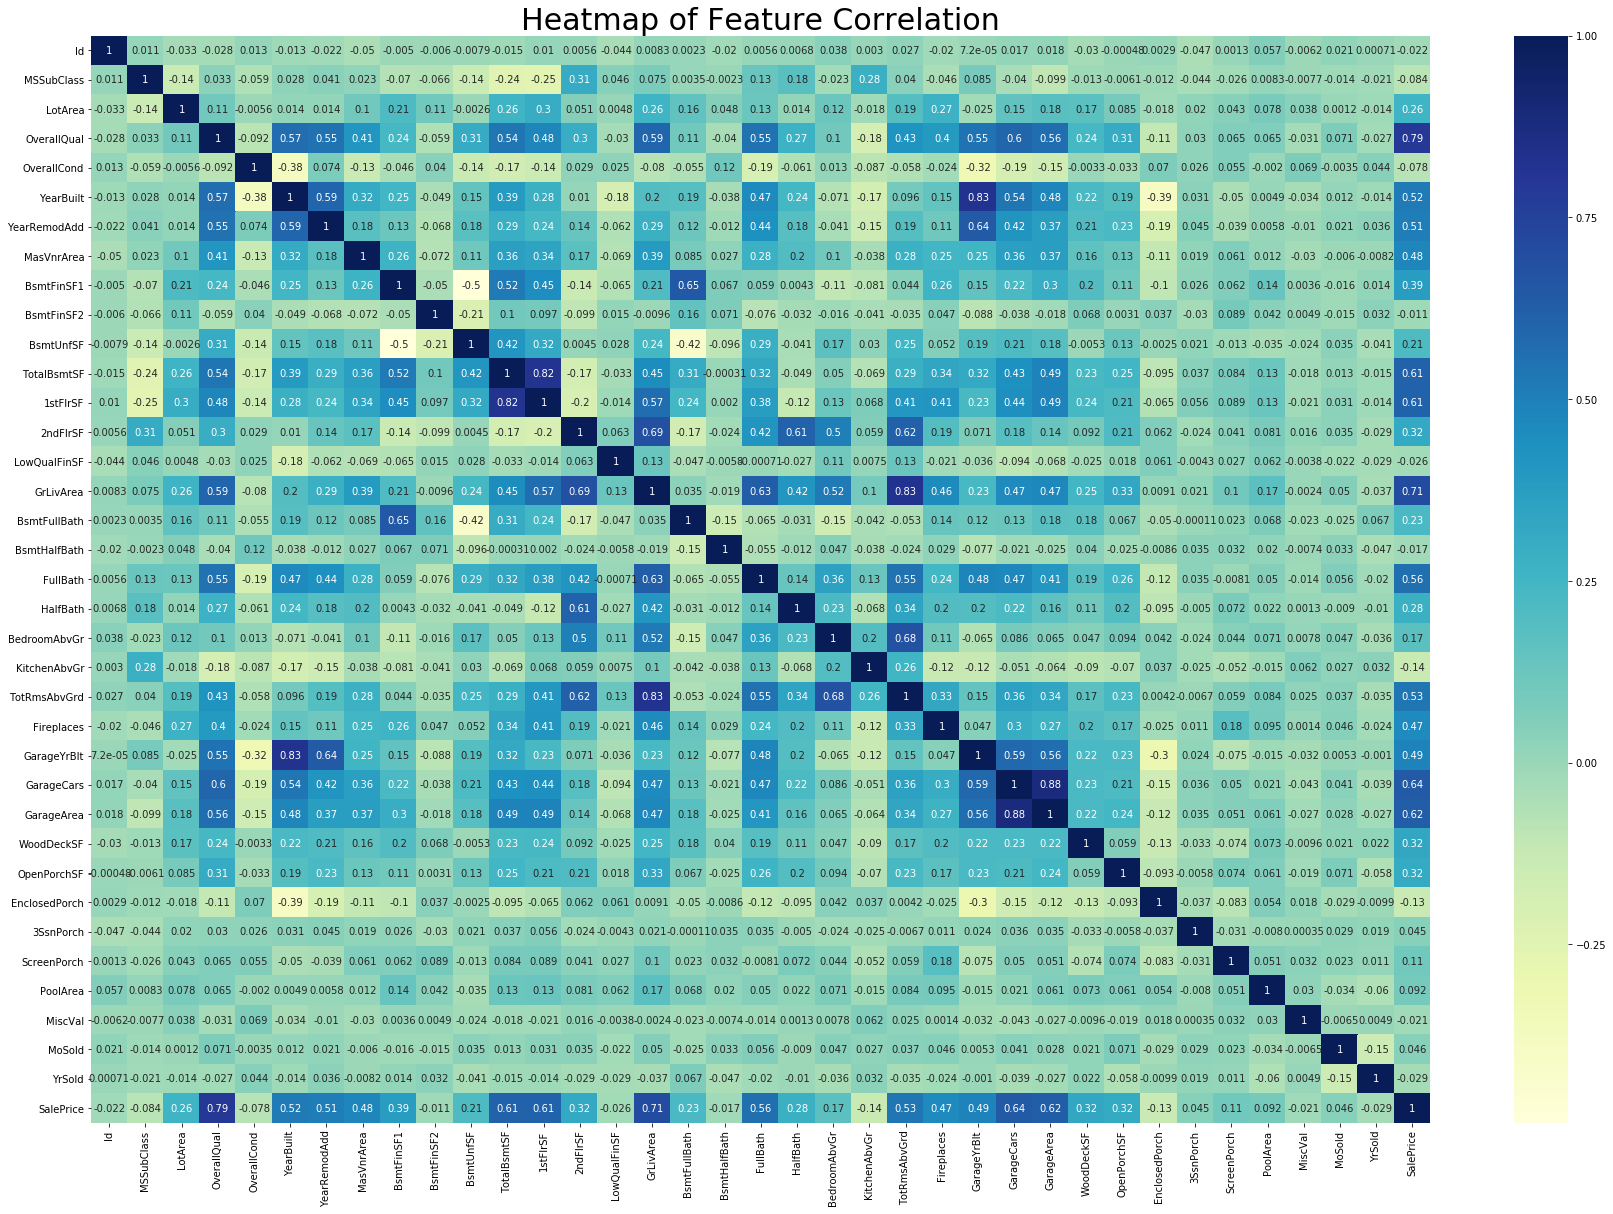

In [9]:
plt.subplots(figsize = (30,20))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True);
plt.title("Heatmap of Feature Correlation", fontsize = 30);

Looking at the correlation heat map we can quickly identify features which are highly related to other features. For example 1stFlSF and TotalBsmntSF are highly correlated which makes sense because generally speaking most basements are full basements (the basement is wearing the first floor like a hat). The same goes for 1stFlSF and 2ndFlSF (This house is a mad hatter).

Another instance is GarageCars and GarageArea. This makes sense because you need more space to store more cars. This is the same rationale for TotRmsAbvGrd (Total rooms above ground) and GrLivArea (ground floor living area).

YearBuilt and GarageYrBlt also appear to be highly correlated. This makes sense because typically the house and the garage are built at the same time.

Let's take some time to graph some of these relationships and see what comes up.

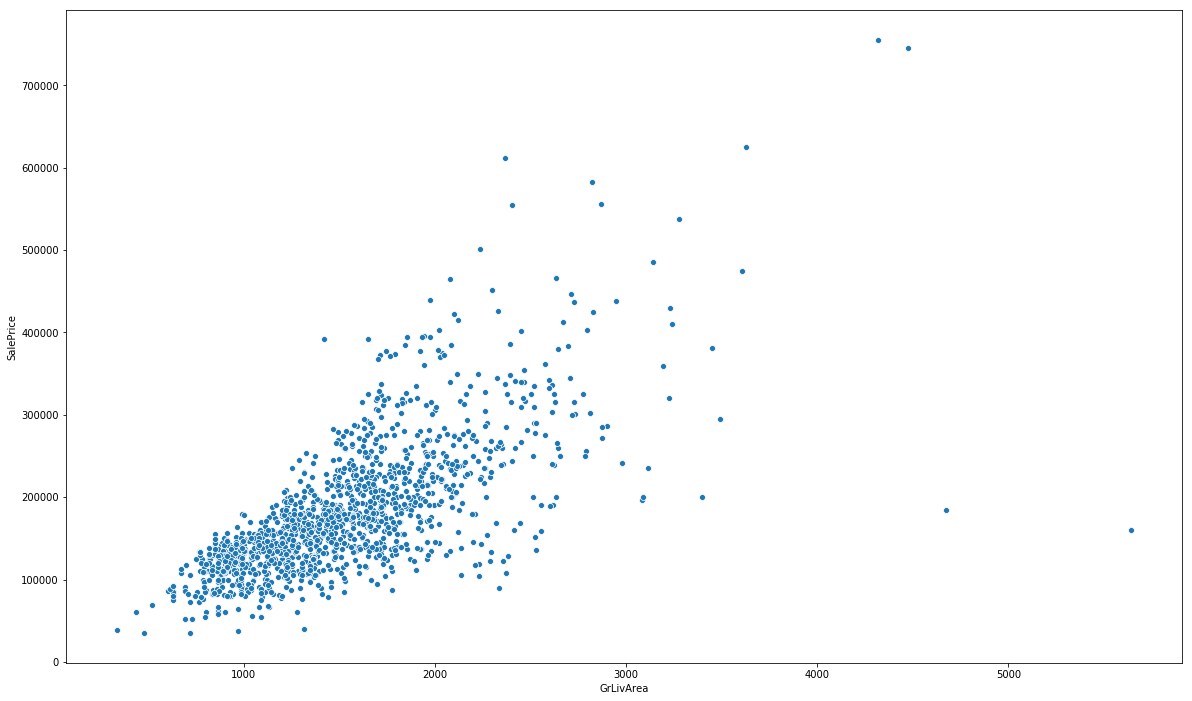

In [10]:
plt.subplots(figsize = (20,12))
sns.scatterplot(x=df['GrLivArea'], y= df['SalePrice']);

In [11]:
filter = (df['GrLivArea'] > 4000) & (df['SalePrice'] < 200000)
df[filter][['GrLivArea', 'SalePrice']]

,GrLivArea,SalePrice
523,4676,184750
1298,5642,160000


As we can see from the graph there are four possible outliers, two with a sale price over $700,000 and two with over 4500 sq. ft. but a much lower price. If we follow the trend of the graph the higher two outliers seem to fit the pattern and we can likely keep these two in however we should probably remove the other two outliers. As this is unique to the training dataset we'll do that below.

In [12]:
df = df[~filter]

In [13]:
mask = df['Electrical'].notna()
df = df.loc[(mask), :]

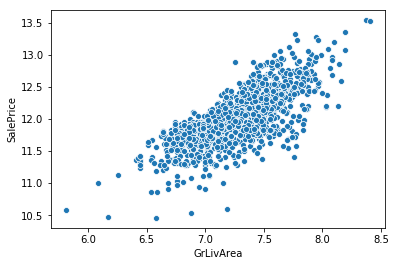

In [14]:
sns.scatterplot(np.log(df['GrLivArea']), np.log(df['SalePrice']));

The Box-Cox test quickly and easily tells us if  we need to perform a transform on our data or not by telling us a lambda value:

* -1. is a reciprocal
* -.5 is a recriprocal square root
* 0.0 is a log transformation
* .5 is a square root transform and
* 1.0 is no transform.

In [15]:
bc_list = ['LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'SalePrice']

for c in bc_list:
    df.loc[df[c] == 0, c] = 0.0000000001
    xt, maxlog = boxcox(df[c])
    
    print("{} lambda = {:g}".format(c, maxlog))

LotArea lambda = -12.7707
TotalBsmtSF lambda = 0.521923
1stFlrSF lambda = -0.00533611
2ndFlrSF lambda = -0.0282768
GrLivArea lambda = 0.070394
GarageArea lambda = 0.417968
SalePrice lambda = -0.0771516


/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2308: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Based on the Box-Cox test we ran on the columns from our dataset, we need to perform the following transformations in our `process_df` function:

- Log
  - LotArea
  - 1stFlrSF
  - 2ndFlrSF
  - SalePrice
  - GrLivArea

- Square root
  - TotalBsmtSF
  - GarageArea
  

In [16]:
df['CentralAir'].isnull().sum()

0

In [17]:
df = pd.read_csv(os.path.join('data','train.csv'))
process_df(df)

/Users/marktrovinger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
